# 测试控制台

你知道吗？阳见惠凪太可爱了

## POD 构建

In [ ]:
from backend.pipeline import quick_build_pod

res = quick_build_pod(
    nc_path="data/cylinder2d.nc",
    r=128,
    center=True,
    var_keys=("u", "v"),
    verbose=True,   # 打印所有中间过程
    plot=True,      # 画出奇异值谱+累计能量图
)

print("实际使用的模态数 r_used =", res["r_used"])
print("前10阶累计能量:", res["cum_energy"][:10])


## 线性单帧 Demo

In [ ]:
from backend.pipeline import quick_test_linear_baseline

res = quick_test_linear_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=0,
    mask_rate=0.02,
    noise_sigma=0.01,
    max_modes=64,      # 前 64 个模态
    modes_per_fig=16,  # 每 16 个为一组：q1-16, q17-32, q33-48, q49-64
    channel=0,
    verbose=True,
)

print("POD 自身截断误差 NMSE =", res["nmse_pod"])
print("线性基线重建 NMSE      =", res["nmse_linear"])


## MLP 单帧 demo

In [ ]:
from backend.pipeline import quick_test_mlp_baseline

res = quick_test_mlp_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=0,
    mask_rate=0.02,
    noise_sigma=0.01,
    mlp_noise_sigma=0.01,
    batch_size=64,
    num_epochs=50,
    lr=1e-3,
    max_modes=64,
    modes_per_fig=16,
    channel=0,
    verbose=True,
)

print("NMSE(POD truncation) =", res["nmse_pod"])
print("NMSE(Linear baseline) =", res["nmse_linear"])
print("NMSE(MLP baseline)   =", res["nmse_mlp"])


## 完整 sweep + 多尺度分析

In [ ]:
from backend.pipeline import quick_full_experiment

result = quick_full_experiment(
    nc_path="data/cylinder2d.nc",
    var_keys=("u", "v"),
    r=128,
    center=True,
    mask_rates=[0.01, 0.02, 0.05, 0.10],
    noise_sigmas=[0.0, 0.01, 0.02],
    pod_bands={"L": (0, 16), "M": (16, 64), "H": (64, 128)},
    train_mask_rate=0.02,
    train_noise_sigma=0.01,
    max_epochs=50,
    device="cuda",
    verbose=True,
)

# 存盘 + 报告
from backend.eval.reports import save_full_experiment_results, generate_experiment_report_md

paths = save_full_experiment_results(result, "artifacts/experiments", "cylinder_exp1")
report_path = generate_experiment_report_md(result, "artifacts/experiments/cylinder_exp1/report.md",
                                            experiment_name="Cylinder-2D p-σ sweep")

result["df_linear"].head(), result["df_mlp"].head(), report_path


[yaml-experiment] Loading configs from configs/cylinder_exp1.yaml ...
[yaml-experiment] Running full evaluation pipeline ...
=== [full-eval] Start full evaluation pipeline ===
[full-eval] Running linear baseline sweep ...
=== [eval-linear] Start linear baseline experiment ===
[eval] Found existing POD in artifacts/pod, skip rebuilding.
  - meta: T=1501, H=80, W=640, C=2, r_used=128, r_eff=128
[eval] Loading full raw data from data/cylinder2d.nc ...
  -> X_thwc shape = (1501, 80, 640, 2), flatten = [1501, 102400], r_eff=128
  -> Projected all snapshots to POD space: A_true shape = (1501, 128)

[eval-linear] mask_rate = 0.0100
  -> total observed entries (with 2 channels) = 1024
  [eval-linear] noise_sigma = 0.0000e+00
    -> NMSE(mean±std) = 6.9381e-01 ± 1.0554e-02, NMAE = 5.7261e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 1.0000e-02
    -> NMSE(mean±std) = 6.9390e-01 ± 1.0944e-02, NMAE = 5.7266e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 2.0000e-02
    -> NMSE(mean±std) =

,model_type,mask_rate,noise_sigma,nmse_mean,nmse_std,nmae_mean,nmae_std,psnr_mean,psnr_std,n_frames,n_obs,band_H,band_L,band_M
0,linear,0.01,0.00,0.693813,0.010554,0.572609,0.020622,11.544678,0.426909,1501,1024,16.574008,23.751365,14.747101
1,linear,0.01,0.01,0.693897,0.010944,0.572657,0.020640,11.544187,0.427133,1501,1024,16.575332,23.751804,14.748044
2,linear,0.01,0.02,0.694096,0.011780,0.572757,0.020671,11.543026,0.428194,1501,1024,16.578468,23.753477,14.750031
3,linear,0.02,0.00,0.092673,0.001409,0.264269,0.009517,20.287563,0.426902,1501,2048,5.160903,10.197800,5.736487
4,linear,0.02,0.01,0.092689,0.001426,0.264296,0.009509,20.286846,0.427383,1501,2048,5.161601,10.197971,5.737071


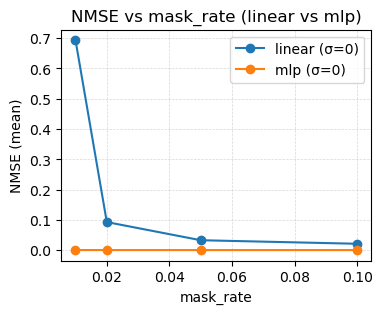

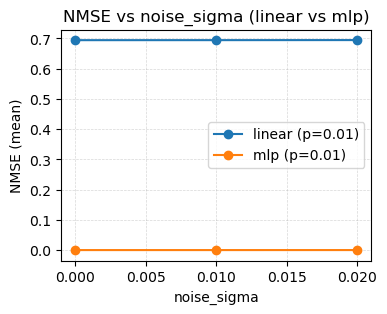

In [1]:
from backend.pipeline import run_experiment_from_yaml

res = run_experiment_from_yaml(
    "configs/cylinder_exp1.yaml",
    experiment_name="cylinder_exp1",
    save_root="artifacts/experiments",
    generate_report=True,
    verbose=True,
)

print("报告路径:", res["report_path"])
res["df_linear"].head()
